# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from tensorflow.keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
    
zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

An example from the reviews:
Text : Entertainment Tonight has been going down hill for the last few years, but as of last night (Aug 17th 2006) they reached a new low.<br /><br />In an effort to try to hype up their broadcast, they deci...
Label: neg


# Prepare Data
Initialize a `SentCharVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We will use a set a simple sentence tokenizer and no word 
tokenizer, so the words will be splitted on spaces. The vocabulary is 
restricted to the provided characters.

In [2]:
from keras_nlp.preprocessing import sent_tokenize
from keras_nlp import SentCharVectorizer

sent_char_vectorizer = SentCharVectorizer(
    sent_tokenize, characters='abcdefghijklmnopqrstuvwxyz', oov_token='#')
sent_char_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {sent_char_vectorizer.num_tokens}')

2020-Apr-09 23:26:54 [INFO    :SentCharVectorizer] - Creating vocabulary.


25000/25000 [==============================] - 4s 151us/step
Vectorizer number of tokens: 28


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [3]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

## Vectorize Data
We apply the fitted vectorizer to the train and test texts. 
Also we have to set the `max_sentences` per text and `max_words` per sentence
and `max_characters` per word. 

In [4]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, y_train, y_val = train_test_split(
    train_texts, y_train, stratify=train_labels, shuffle=True, random_state=45)


**Attention**: We *must* pass the same number `max_sentences` per text and 
`max_words` per sentence and `max_characters` per word. of `max_tokens` when 
converting different text sets. If we don't, then it is almost certain that 
the results will have different numbers of columns because the set are likely 
to have different number of tokens.

In [5]:
max_sentences, max_tokens, max_characters = 10, 15, 30
batch_size = 50
train_generator = sent_char_vectorizer.texts_to_vectors_generator(
    train_texts,
    y_train,
    shape=(max_sentences, max_tokens, max_characters),
    batch_size=50)

val_generator = sent_char_vectorizer.texts_to_vectors_generator(
    val_texts,
    y_val,
    shape=(max_sentences, max_tokens, max_characters),
    batch_size=50)

# Neural Network
Here we define a toy network for demonstration purpose.
The model has two layers. The first encodes the characters of the words of a 
sentence providing sentence vectors. The second encodes the sentence
vectors to a document vector.

## Characters Encoder Model

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, TimeDistributed, \
    Dropout, Flatten, Dense, Bidirectional, LSTM

rnn_params = dict(dropout=0.2, return_sequences=True, recurrent_dropout=0.2)

chars_input = Input(
    shape=(
        max_tokens,
        max_characters,
    ), name='Input', dtype='int32')
chars_embeddings = TimeDistributed(
    Embedding(
        input_dim=sent_char_vectorizer.num_tokens,
        output_dim=20,
        input_length=max_characters,
        mask_zero=False,
        trainable=True),
    name='Embeddings')(chars_input)
x = Dropout(0.4, name='Input_Dropout')(chars_embeddings)
x = Flatten(name='Flatten')(x)
x = Dropout(0.4, name='Dropout')(x)
char_model = Model(chars_input, x)

print(char_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 15, 30)]          0         
_________________________________________________________________
Embeddings (TimeDistributed) (None, 15, 30, 20)        560       
_________________________________________________________________
Input_Dropout (Dropout)      (None, 15, 30, 20)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 9000)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 9000)              0         
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________
None


## Sentence Encoder Model

In [7]:
sent_input = Input(
    shape=(max_sentences, max_tokens, max_characters), dtype='int32', name='Sent_Input')
sent_input_over_word_model = TimeDistributed(
    char_model, name='Char_Model')(sent_input)
sent_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Sents_Encoder')(sent_input_over_word_model)
x = Dropout(0.3, name='Dropout')(sent_encoder)
x = Flatten(name='Flatten')(x)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(sent_input, predictions)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary(90))

Model: "model_1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Sent_Input (InputLayer)                 [(None, 10, 15, 30)]                0             
__________________________________________________________________________________________
Char_Model (TimeDistributed)            (None, 10, 9000)                    560           
__________________________________________________________________________________________
Sents_Encoder (Bidirectional)           (None, 10, 200)                     7280800       
__________________________________________________________________________________________
Dropout (Dropout)                       (None, 10, 200)                     0             
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 2000)                     

## Train Model

In [8]:
steps_per_epoch = len(train_texts) // batch_size
if steps_per_epoch % batch_size:
    steps_per_epoch += 1
val_steps_per_epoch = len(val_texts) // batch_size
if val_steps_per_epoch % batch_size:
    val_steps_per_epoch += 1

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=5)

  ...
    to  
  ['...']


2020-Apr-09 23:28:09 [WARNING :tensorflow  ] - sample_weight modes were coerced from
  ...
    to  
  ['...']


  ...
    to  
  ['...']


2020-Apr-09 23:28:09 [WARNING :tensorflow  ] - sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 376 steps, validate for 126 steps
Epoch 1/5
376/376 [==============================] - 88s 233ms/step - loss: 0.6815 - acc: 0.5485 - val_loss: 0.6437 - val_acc: 0.6283
Epoch 2/5
376/376 [==============================] - 84s 225ms/step - loss: 0.6318 - acc: 0.6358 - val_loss: 0.6308 - val_acc: 0.6384
Epoch 3/5
376/376 [==============================] - 84s 223ms/step - loss: 0.6009 - acc: 0.6701 - val_loss: 0.6159 - val_acc: 0.6614
Epoch 4/5
376/376 [==============================] - 84s 222ms/step - loss: 0.5687 - acc: 0.6980 - val_loss: 0.6218 - val_acc: 0.6533
Epoch 5/5
376/376 [==============================] - 83s 221ms/step - loss: 0.5409 - acc: 0.7220 - val_loss: 0.6583 - val_acc: 0.6332


## Model Evaluation

In [9]:
import numpy as np
from sklearn.metrics import classification_report

steps = len(test_texts) // batch_size
if len(test_texts) % batch_size:
    steps += 1
test_generator = sent_char_vectorizer.texts_to_vectors_generator(
    test_texts,
    y_test,
    shape=(max_sentences, max_tokens, max_characters),
    batch_size=batch_size)
predictions = model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.round(predictions)
print(
    classification_report(
        y_test, y_pred, digits=4, target_names=['neg', 'pos']))

500/500 [==============================] - 41s 82ms/step
              precision    recall  f1-score   support

         neg     0.6121    0.7717    0.6827     12500
         pos     0.6912    0.5110    0.5876     12500

    accuracy                         0.6414     25000
   macro avg     0.6517    0.6414    0.6352     25000
weighted avg     0.6517    0.6414    0.6352     25000



# Plot Accuracy and Loss

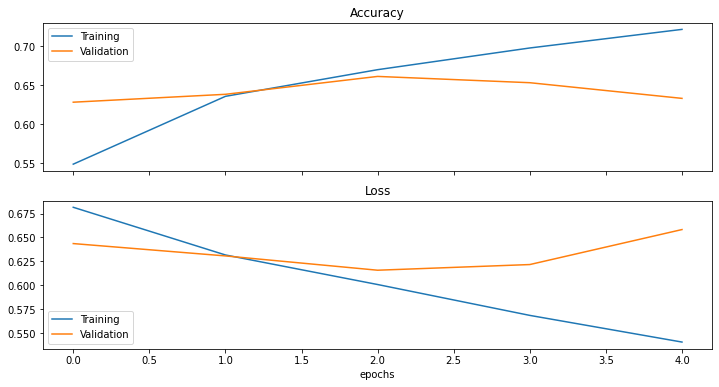

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()